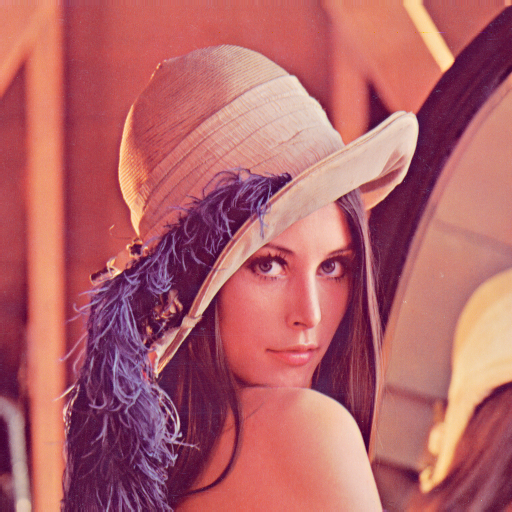

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image = cv2.imread("/content/Lena_Image.png")
if image is None:
    print("Error: Could not read the image. Check the file path.")
    exit()

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# 3. Extraction of Image size
height, width, channels = image.shape
print(f"Image Dimensions: Width = {width}, Height = {height}, Channels = {channels}")

Image Dimensions: Width = 512, Height = 512, Channels = 3


In [ ]:
# 4. Calculation of Image Pixels
total_pixels = height * width
print(f"Total Pixels in Image: {total_pixels}")

Total Pixels in Image: 262144


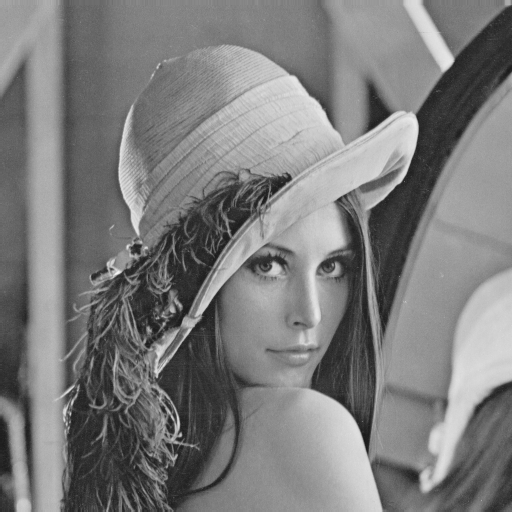

In [ ]:
# 5. Convert RGB to Grayscale image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite("gray_image.jpg", gray_image)
cv2_imshow( gray_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

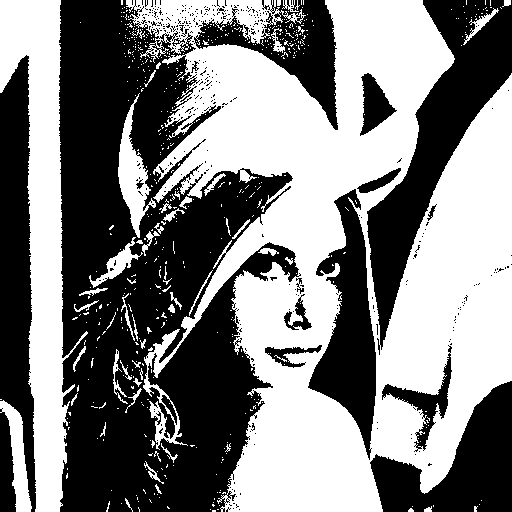

In [ ]:
# 6. Convert Grayscale to Binary image by using a threshold
threshold = 128
_, binary_image = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)
cv2.imwrite("binary_image.jpg", binary_image)
cv2_imshow( binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:

# Count the area of black pixels
black_pixel_count = np.sum(binary_image == 0)
print(f"Black Pixel Area: {black_pixel_count} pixels")
print(f"Image Size: {binary_image.shape}")

cv2.imwrite("converted_image.jpg", binary_image)

Black Pixel Area: 130547 pixels
Image Size: (512, 512)


True

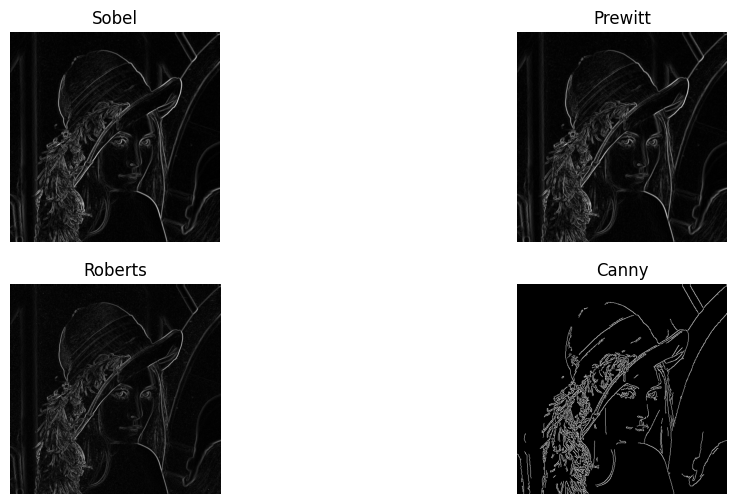

In [ ]:
from matplotlib import pyplot as plt

# Convert to float before computing magnitude
sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

# Prewitt Operator
kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)
kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=np.float32)
prewitt_x = cv2.filter2D(gray_image, cv2.CV_64F, kernelx)
prewitt_y = cv2.filter2D(gray_image, cv2.CV_64F, kernely)
prewitt_combined = np.sqrt(np.square(prewitt_x) + np.square(prewitt_y))

# Roberts Cross Operator
roberts_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
roberts_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)
roberts_x_img = cv2.filter2D(gray_image, cv2.CV_64F, roberts_x)
roberts_y_img = cv2.filter2D(gray_image, cv2.CV_64F, roberts_y)
roberts_combined = np.sqrt(np.square(roberts_x_img) + np.square(roberts_y_img))

# Canny Edge Detection
canny_edges = cv2.Canny(gray_image, 100, 200)

# Display results
plt.figure(figsize=(12, 6))
titles = ["Sobel", "Prewitt", "Roberts", "Canny"]
images = [sobel_combined, prewitt_combined, roberts_combined, canny_edges]

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.axis("off")

plt.show()


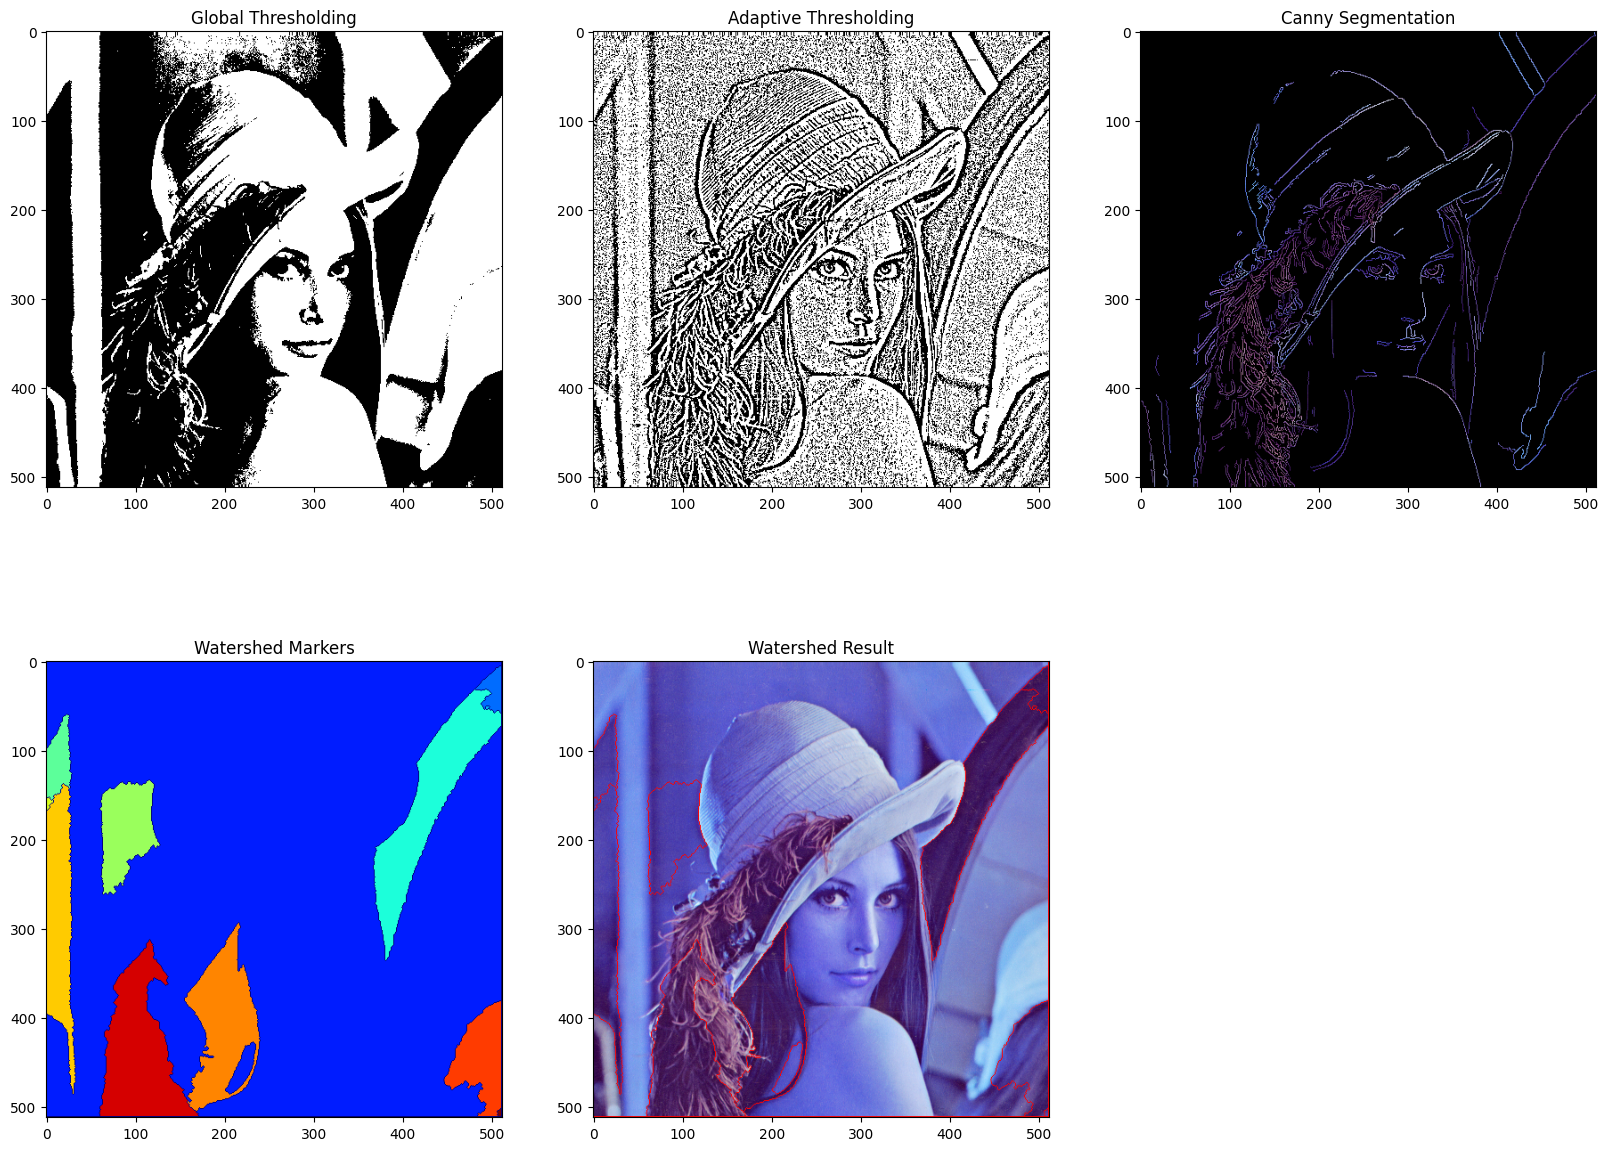

In [ ]:
# Task 2.2: Image Segmentation
gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# i. Global Thresholding
_, global_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# ii. Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(gray, 255,
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)

# iii. Edge Detection Segmentation (Canny)
canny=cv2.Canny(gray_image, 100, 200)
canny_segmented = cv2.bitwise_and(image, image, mask=canny)

# iv. Watershed Algorithm
# Threshold the input image
ret, thresh = cv2.threshold(gray, 0, 255,
                           cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(image, markers)
watershed_result = image.copy()
watershed_result[markers == -1] = [255,0,0]

# Plot segmentation results
plt.figure(figsize=(20, 15))
plt.subplot(231), plt.imshow(global_thresh, cmap='gray'), plt.title('Global Thresholding')
plt.subplot(232), plt.imshow(adaptive_thresh, cmap='gray'), plt.title('Adaptive Thresholding')
plt.subplot(233), plt.imshow(canny_segmented), plt.title('Canny Segmentation')
plt.subplot(234), plt.imshow(markers, cmap='jet'), plt.title('Watershed Markers')
plt.subplot(235), plt.imshow(watershed_result), plt.title('Watershed Result')
plt.show()